# Imports

In [11]:
!pip install folium

import numpy as np 
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [12]:
toronto_data_w_gsptl = pd.read_csv('toronto_data_w_gsptl.csv')

In [13]:
CLIENT_ID = 'VDOBXZN3URETAF2DUZDCL31M2IVO33GTC3CEFHYU22AX4G25' # your Foursquare ID
CLIENT_SECRET = '0LKMAJOWF5ZCUDJ51OSSDGFNN0RMRGTRBG4F3JWV0MIZMCD0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [14]:
toronto_data_w_gsptl.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
toronto_data_w_gsptl.drop(columns = 'Postcode',inplace=True)
print(print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data_w_gsptl['Borough'].unique()),
        toronto_data_w_gsptl.shape[0])))
toronto_data_w_gsptl.head()

The dataframe has 11 boroughs and 103 neighborhoods.
None


,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


#### Create a map of Toronto 

In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_data_w_gsptl.Latitude.mean(),
                                   toronto_data_w_gsptl.Longitude.mean()], zoom_start=10)

# add markers to map
iterator = zip(toronto_data_w_gsptl['Latitude'], toronto_data_w_gsptl['Longitude'],
                toronto_data_w_gsptl['Borough'], toronto_data_w_gsptl['Neighbourhood'])
for lat, lng, borough, neighborhood in iterator:
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Explore

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        while True:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                continue
            
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
toronto_venues = getNearbyVenues(names=toronto_data_w_gsptl['Neighbourhood'],
                                    latitudes=toronto_data_w_gsptl['Latitude'],
                                    longitudes=toronto_data_w_gsptl['Longitude']
                                   )
##Checkpoint
toronto_venues.to_csv('toronto_venues.csv', index=False)

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [24]:
toronto_venues = pd.read_csv('toronto_venues.csv')

In [25]:
print(toronto_venues.shape)
toronto_venues.head()

(2201, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [26]:
venue_counts = toronto_venues.groupby('Neighborhood').Venue.count()
venue_counts

Neighborhood
Adelaide, King, Richmond                                                                                                                  100
Agincourt                                                                                                                                   4
Agincourt North, L'Amoreaux East, Milliken, Steeles East                                                                                    3
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown                               8
Alderwood, Long Branch                                                                                                                     10
Bathurst Manor, Downsview North, Wilson Heights                                                                                            19
Bayview Village                                                                                                                        

look at the distribution

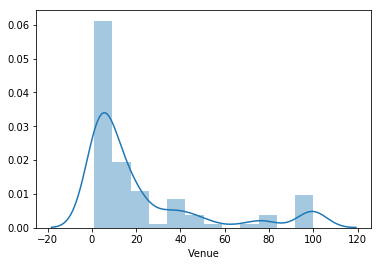

In [27]:
sns.distplot(venue_counts);

neighboorhoods that have more than 75% 

In [28]:
print(f"""The're is only {len(venue_counts[venue_counts>=75.0])/len(venue_counts)*100}% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is {len(venue_counts[venue_counts>=75.0])}""")

The're is only 11.11111111111111% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is 11


neighboorhoods have more than 25% 

In [29]:
print(f"""The're is only {len(venue_counts[venue_counts>=25.0])/len(venue_counts)*100}% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is {len(venue_counts[venue_counts>=25.0])}""")

The're is only 25.252525252525253% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is 25


Neighbourhoods with more than 25 venues 

In [30]:
nbrhoods_used = venue_counts[venue_counts>=25.0].index 
toronto_venues_filtered = toronto_venues[toronto_venues.Neighborhood.isin(nbrhoods_used)]
print(toronto_venues_filtered.shape)
toronto_venues_filtered.head()

(1612, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
96,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,The LEGO Store,43.778207,-79.343483,Toy / Game Store
97,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Michel's Baguette,43.777082,-79.344557,Bakery
98,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,CF Fairview Mall,43.777994,-79.343665,Shopping Mall
99,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,DAVIDsTEA,43.777593,-79.345089,Tea Room
100,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Hero Certified Burgers,43.777295,-79.344584,Burger Joint


## Analyze

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_filtered[['Venue Category']],
                                prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_filtered['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + [_ for _ in toronto_onehot.columns if _ !='Neighborhood']
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
96,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
97,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,"Fairview, Henry Farm

And let's examine the new dataframe size.

In [32]:
toronto_onehot.shape

(1612, 213)

#### group rows by neighborhood  taking the mean of the frequency of occurrence of each category

In [33]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.020000,0.0,0.0,0.010000,0.0,0.02,0.000000,0.000000,0.030000,0.000000,0.030000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.020000,0.0,0.01,0.020000,0.0,0.000000,0.01,0.010000,0.01,0.0,0.000000,0.000000,0.060000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.02,0.000000,0.060000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.020000,0.0,0.000000,0.0,0.0,0.0,0.010000,0.010000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.01,0.000000,0.000000,0.01,0.0,0.0,0.000000,0.000000,0.0,0.01,0.01,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.010000,0.0,0.0,0.020000,0.0,0.000000,0.01,0.0,0.010000,0.01,0.000000,0.000000,0.000000,0.03,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.010000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.0,0.0,0.000000,0.0,0.01,0.0,0.000000,0.020000,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.000000,0.000000,0

#### Let's confirm the new size

In [34]:
toronto_grouped.shape

(25, 213)

#### Let's print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
         venue  freq
0         Café  0.06
1   Restaurant  0.06
2  Coffee Shop  0.06
3          Gym  0.03
4       Bakery  0.03


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1          Restaurant  0.08
2         Coffee Shop  0.08
3         Pizza Place  0.08
4  Italian Restaurant  0.08


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.05
2  Farmers Market  0.04
3            Café  0.04
4     Cheese Shop  0.04


----Cabbagetown, St. James Town----
                venue  freq
0         Coffee Shop  0.09
1                Café  0.04
2                Park  0.04
3  Italian Restaurant  0.04
4          Restaurant  0.04


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.18
1   Italian Restaurant  0.05
2  Japanese Restaurant  0.04
3      Thai Restaurant  0.04
4       Sandwich Place  0.04


----Chinatown, Grange Park, Kensington Market----
  

#### Let's put that into a *pandas* dataframe

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = \
    return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Restaurant,Café,Coffee Shop,Hotel,Gym,Thai Restaurant,Bakery,Bar,Sushi Restaurant,Salad Place
1,"Bedford Park, Lawrence Manor East",Restaurant,Italian Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Grocery Store,Pharmacy,Butcher,Fast Food Restaurant,Café
2,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Cheese Shop,Beer Bar,Café,Restaurant,Bakery,Seafood Restaurant,Comfort Food Restaurant
3,"Cabbagetown, St. James Town",Coffee Shop,Bakery,Pub,Restaurant,Café,Pizza Place,Italian Restaurant,Park,Chinese Restaurant,Convenience Store
4,Central Bay Street,Coffee Shop,Italian Restaurant,Burger Joint,Sandwich Place,Japanese Restaurant,Thai Restaurant,Dessert Shop,Salad Place,Café,Spa


## Cluster

In [39]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 1, 1, 1, 4, 4, 1, 3, 1], dtype=int32)

In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data_w_gsptl

toronto_data_w_gsptl.head()



,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [58]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough,Woburn,43.770992,-79.216917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Scarborough,Cedarbrae,43.773136,-79.239476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, let's visualize the resulting clusters

In [59]:
# create map
map_clusters = folium.Map(location=[toronto_data_w_gsptl.Latitude.mean(),
                                   toronto_data_w_gsptl.Longitude.mean()], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters